In [ ]:
import numpy as np 
import tensorflow as tf 
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

warnings.filterwarnings('ignore')

drive.mount('/content/drive/')

**Load Datasets**

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAINFILEPATH = '/content/drive/MyDrive/data/train'
VALIDFILEPATH = '/content/drive/MyDrive/data/valid'
TESTFILEPATH = '/content/drive/MyDrive/data/test'

batch_size = 32

datagen =  ImageDataGenerator(preprocessing_function =tf.keras.applications.mobilenet.preprocess_input,
                              horizontal_flip=True,
                              zoom_range=0.2,
                              shear_range=0.2,
                              rotation_range=30,
                              fill_mode='nearest')

train_generator = datagen.flow_from_directory(TRAINFILEPATH,
                                   target_size=(224,224),
                                   batch_size = batch_size , 
                                   class_mode = 'categorical')


datagen2 =  ImageDataGenerator(preprocessing_function =tf.keras.applications.mobilenet.preprocess_input)

validation_generator = datagen2.flow_from_directory(VALIDFILEPATH,
                                   target_size=(224,224),
                                   batch_size = batch_size , 
                                   class_mode = 'categorical')

test_generator = datagen2.flow_from_directory(TESTFILEPATH,
                                   target_size=(224,224),
                                   batch_size = batch_size , 
                                   shuffle=False,
                                   class_mode = 'categorical')

Found 2960 images belonging to 23 classes.
Found 689 images belonging to 23 classes.
Found 610 images belonging to 23 classes.


**Inspect the data**

In [4]:
test = pd.Series(test_generator.classes).value_counts().sort_index()
train = pd.Series(train_generator.classes).value_counts().sort_index()
valid = pd.Series(validation_generator.classes).value_counts().sort_index()
classes = pd.Series(train_generator.class_indices.keys())
df = pd.concat([classes,train,valid,test],axis=1).rename(columns={0:'Class',1:'Train Data Count',2:'Valid Data Count',3:'Test Data Count'}).set_index('Class')
df['Valid Data Count']=df['Valid Data Count'].fillna(0).astype('int')
df.style.background_gradient(cmap='viridis_r')

,Train Data Count,Valid Data Count,Test Data Count
Class,,,
Abdeen palace,97,30,25
Bab Zuweila,101,30,23
Baron palace,191,30,30
Bent Pyramid,216,30,29
Cairo Tower,245,30,25
Deir al-Bahari (Hatshepsut Temple),93,30,25
Edfu's Temple of Horus,118,30,24
Great Sphinx of Giza,113,30,25
Kalabsha Temple,113,30,24


**Visualize Data Samples**

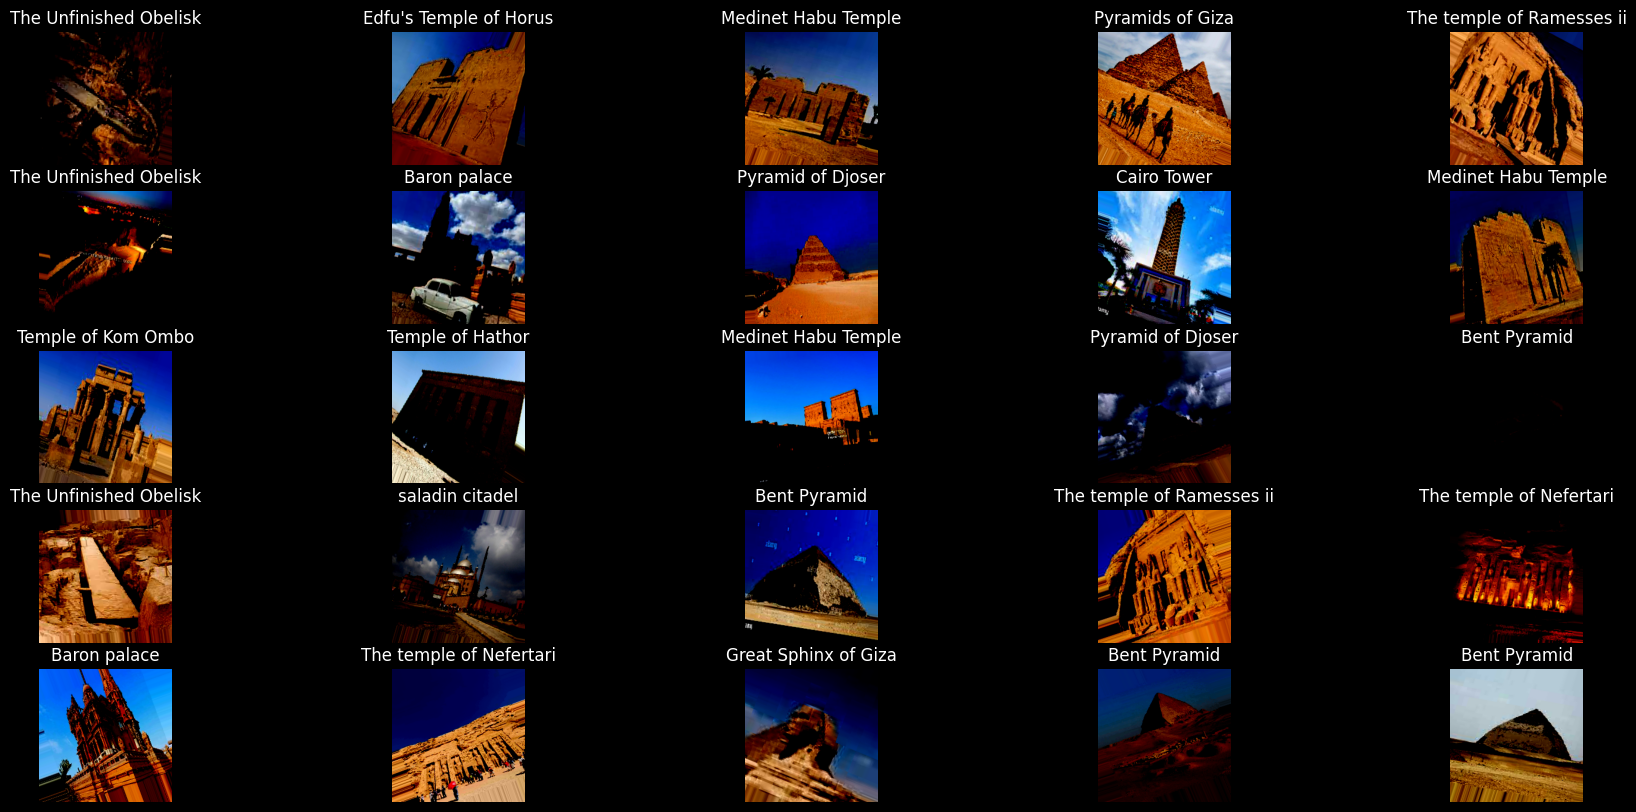

In [16]:
plt.figure(figsize=(22, 10))
plt.style.use('dark_background')
x_batch, y_batch = next(train_generator)
for i in range (0,25):
    plt.subplot(5, 5, i+1)
    image = x_batch[i]
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.title(list(train_generator.class_indices)[y_batch[i].argmax()])
    plt.axis('off')


**Load Base Model**

In [ ]:
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

**Add layers to model**

In [ ]:
x = mobile.layers[-5].output
x = tf.keras.layers.Reshape(target_shape=(1024,))(x)
output = tf.keras.layers.Dense(units=23,activation='softmax')(x)

model = tf.keras.models.Model(inputs=mobile.input,outputs=output)

for layer in model.layers[:-23]:
  layer.trainable = False

**Fitting the model**

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss= tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics= ['accuracy'])

es = EarlyStopping(monitor='val_accuracy',mode='max',verbose=1,patience=7)
mc = ModelCheckpoint('best_model.h5',monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)  

history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples//batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples//batch_size,
    epochs = 20,
    verbose=2,
    callbacks=[es,mc])
history

Epoch 1/20

Epoch 1: val_accuracy improved from -inf to 0.63542, saving model to best_model.h5
92/92 - 2425s - loss: 1.2421 - accuracy: 0.6814 - val_loss: 1.1625 - val_accuracy: 0.6354 - 2425s/epoch - 26s/step
Epoch 2/20

Epoch 2: val_accuracy improved from 0.63542 to 0.83929, saving model to best_model.h5
92/92 - 75s - loss: 0.3201 - accuracy: 0.9286 - val_loss: 0.5701 - val_accuracy: 0.8393 - 75s/epoch - 815ms/step
Epoch 3/20

Epoch 3: val_accuracy improved from 0.83929 to 0.87649, saving model to best_model.h5
92/92 - 71s - loss: 0.1843 - accuracy: 0.9628 - val_loss: 0.4570 - val_accuracy: 0.8765 - 71s/epoch - 770ms/step
Epoch 4/20

Epoch 4: val_accuracy improved from 0.87649 to 0.90774, saving model to best_model.h5
92/92 - 81s - loss: 0.1190 - accuracy: 0.9829 - val_loss: 0.3412 - val_accuracy: 0.9077 - 81s/epoch - 879ms/step
Epoch 5/20

Epoch 5: val_accuracy did not improve from 0.90774
92/92 - 87s - loss: 0.0923 - accuracy: 0.9839 - val_loss: 0.3705 - val_accuracy: 0.9077 - 87s/

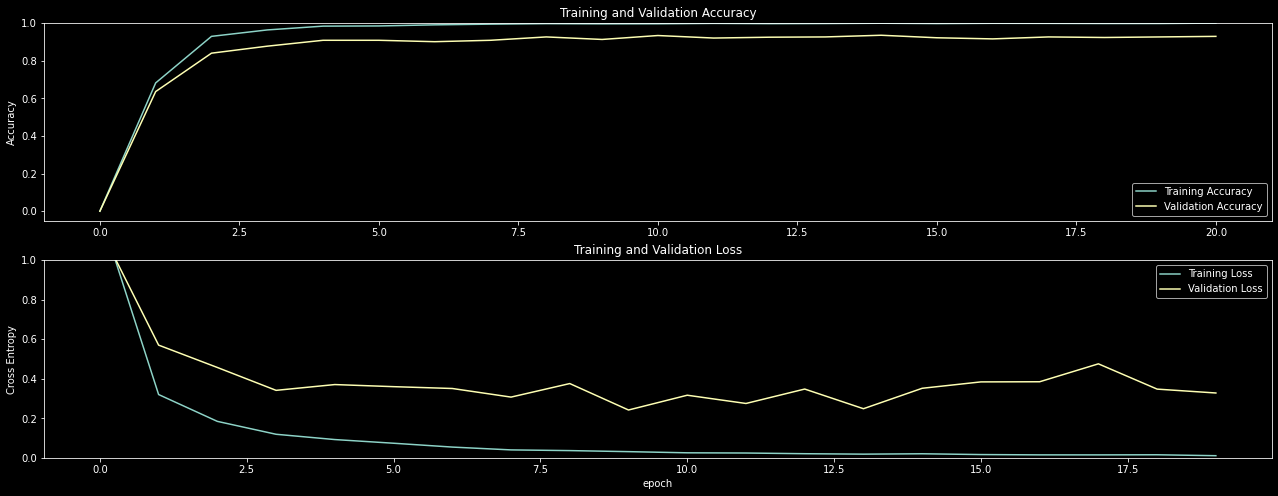

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(22, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Fine tune all layers of the model**

In [ ]:
#Fine-tuning the Model
mobile.trainable = True

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss= tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics= ['accuracy'])

initial_epoch = history.epoch[-1]
fine_tune_epochs = 10
total_epochs =  initial_epoch + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples//batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples//batch_size,
    initial_epoch=initial_epoch,
    epochs = total_epochs,
    verbose=2,
    callbacks=[mc])
history_fine

Epoch 20/29

Epoch 20: val_accuracy did not improve from 0.93452
92/92 - 87s - loss: 0.0240 - accuracy: 0.9966 - val_loss: 0.3067 - val_accuracy: 0.9167 - 87s/epoch - 948ms/step
Epoch 21/29

Epoch 21: val_accuracy did not improve from 0.93452
92/92 - 73s - loss: 0.0189 - accuracy: 0.9993 - val_loss: 0.3444 - val_accuracy: 0.9122 - 73s/epoch - 798ms/step
Epoch 22/29

Epoch 22: val_accuracy did not improve from 0.93452
92/92 - 74s - loss: 0.0172 - accuracy: 0.9966 - val_loss: 0.3473 - val_accuracy: 0.9167 - 74s/epoch - 805ms/step
Epoch 23/29

Epoch 23: val_accuracy did not improve from 0.93452
92/92 - 72s - loss: 0.0149 - accuracy: 0.9990 - val_loss: 0.3649 - val_accuracy: 0.9167 - 72s/epoch - 788ms/step
Epoch 24/29

Epoch 24: val_accuracy did not improve from 0.93452
92/92 - 72s - loss: 0.0147 - accuracy: 0.9980 - val_loss: 0.3346 - val_accuracy: 0.9167 - 72s/epoch - 780ms/step
Epoch 25/29

Epoch 25: val_accuracy did not improve from 0.93452
92/92 - 72s - loss: 0.0109 - accuracy: 0.9993

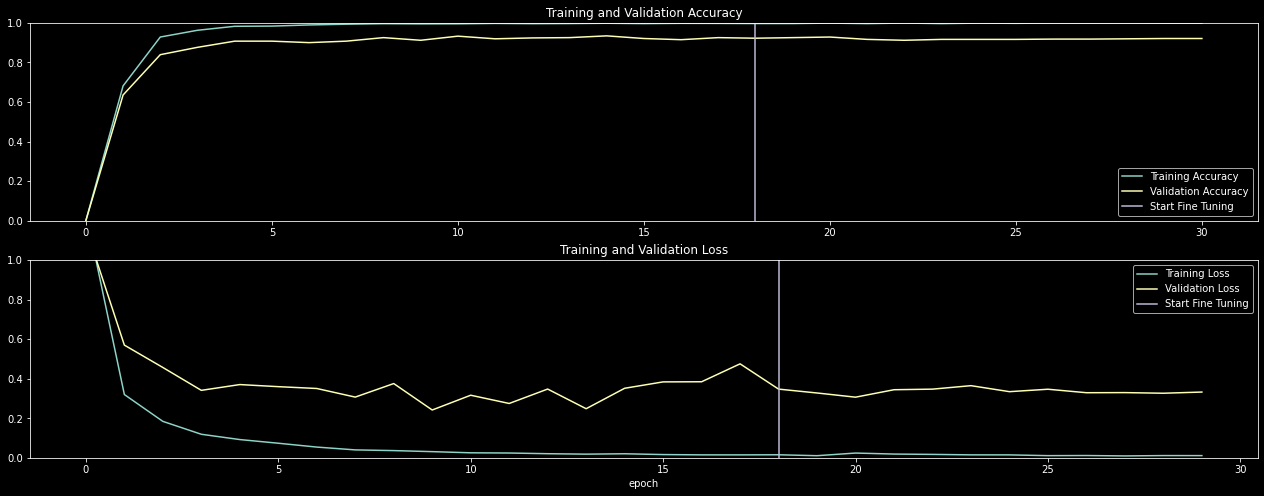

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(22, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epoch-1,initial_epoch-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epoch-1,initial_epoch-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Evaluating**

In [ ]:
scores = model.evaluate(test_generator)
print("%s%s: %0.2f%%"%("evaluate_generator ",model.metrics_names[1],scores[1]*100))

20/20 [==============================] - 471s 25s/step - loss: 0.1602 - accuracy: 0.9607
evaluate_generator accuracy: 96.07%


In [ ]:
pred = model.predict(test_generator,verbose=1)
y_pred = np.argmax(pred, axis=1)

20/20 [==============================] - 10s 466ms/step


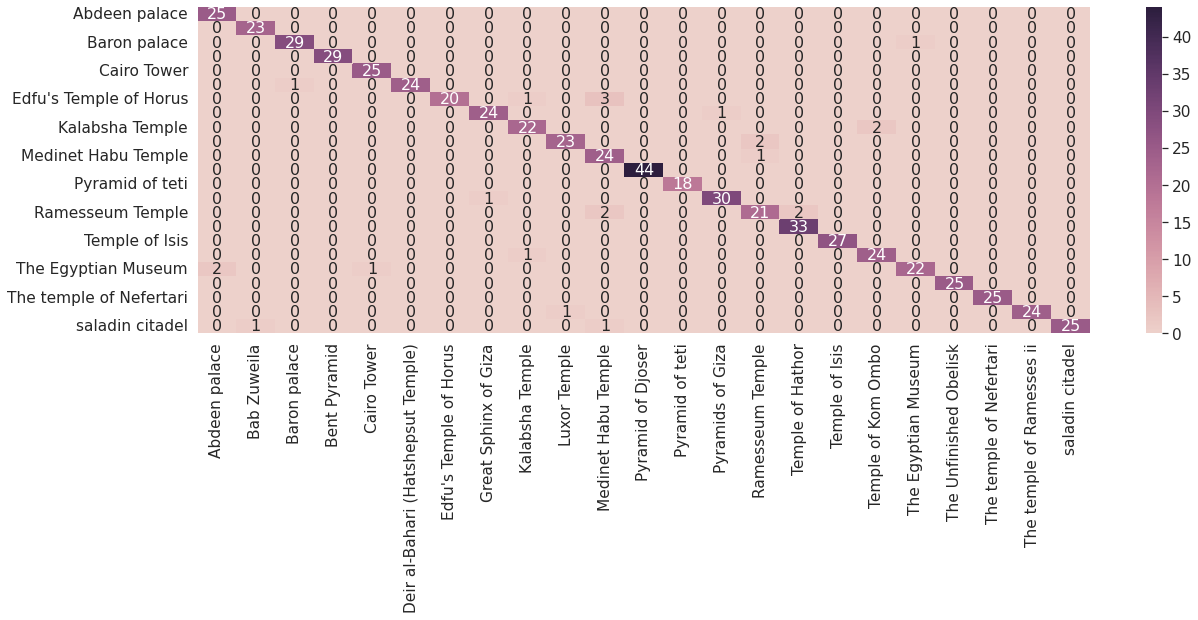

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.style.use('ggplot')

cm = confusion_matrix(y_true = test_generator.classes,y_pred= y_pred)
cm = pd.DataFrame(cm, index=train_generator.class_indices.keys(), columns=train_generator.class_indices.keys())
plt.figure(figsize=(20,6))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={"size": 16},cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()